# FIG CESM run evaluations

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
#import verif_utils as vu

In [2]:
import pandas as pd

In [3]:
import matplotlib.dates as mdates

In [4]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [99]:
from matplotlib.colors import BoundaryNorm, ListedColormap

In [6]:
import matplotlib.lines as mlines

In [7]:
fig_keys = {
    'dpi': 150, 
    'orientation':'portrait', 
    'bbox_inches':'tight', 
    'pad_inches':0.1, 
    'transparent':False
}

In [8]:
need_publish = True

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [9]:
from numpy.lib.stride_tricks import sliding_window_view

def moving_average_axis(a, window, axis=-1, pad_mode="reflect"):
    a = np.asarray(a, dtype=float)
    if window < 1:
        raise ValueError("window must be >= 1")

    # asymmetric split works for even/odd windows
    pad_left  = (window - 1) // 2
    pad_right =  window // 2

    # Build pad widths for all axes; pad only along the chosen axis
    pad_widths = [(0, 0)] * a.ndim
    pad_widths[axis] = (pad_left, pad_right)

    apad = np.pad(a, pad_widths, mode=pad_mode)

    # Sliding windows along `axis`, then average over the last dim (window)
    sw = sliding_window_view(apad, window_shape=window, axis=axis)
    return sw.mean(axis=-1)

## Prep data

In [17]:
static_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static_LAKE.zarr'
ds_static = xr.open_zarr(static_name)
lon_WRF = ds_static['XLONG'].values
lat_WRF = ds_static['XLAT'].values

In [31]:
# fn_static_wrf = '/glade/campaign/collections/rda/data/d559000/INVARIANT/wrfconstants_usgs404.nc'
# ds_static_wrf = xr.open_dataset(fn_static_wrf)

In [128]:
Noah_LU = [
    'Evergreen Needleleaf Forest',
    'Evergreen Broadleaf Forest',
    'Deciduous Needleleaf Forest',
    'Deciduous Broadleaf Forest',
    'Mixed Forest',
    'Closed Shrubland',
    'Open Shrubland',
    'Woody Savanna',
    'Savanna',
    'Grassland',
    'Permanent Wetland',
    'Cropland',
    'Urban and Built-up',
    'Cropland/Natural Veg. Mosaic',
    'Snow and Ice',
    'Barren or Sparsely Vegetated',
    'Water',
    'Herbaceous Tundra',
    'Wooded Tundra',
    'Mixed Tundra',
]

In [33]:
elev = ds_static['HGT_M'].values
lu = ds_static['lu_norm'].values * 17
cat_valid = np.unique(lu)

In [120]:
cat_valid

array([ 1.,  2.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       16., 17.], dtype=float32)

## Plot

In [34]:
my_colors = gu.ksha_color_set_summon(color_set=0)
cyan = my_colors['cyan']
blue = my_colors['blue']
red = my_colors['red']
orange = my_colors['orange']

In [35]:
# line_keys = {}
# line_keys['B3H'] = {'linewidth': 3, 'linestyle': '--', 'color': blue, 'alpha': 1, 'zorder': 3, 'label': ''}
# line_keys['B6H'] = {'linewidth': 3, 'linestyle': '--', 'color': red, 'alpha': 1, 'zorder': 4, 'label': ''}
# line_keys['GDAS'] = {'linewidth': 3, 'linestyle': '-', 'color': orange, 'alpha': 1, 'zorder': 2, 'label': ''}
# line_keys['target'] = {'linewidth': 2.5, 'linestyle': '--', 'color': 'k', 'alpha': 1, 'zorder': 1, 'label': ''}

In [36]:
scale_param = '50m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling
    # GL = ax.gridlines(crs=ccrs.PlateCarree(), 
    #                   draw_labels=False, x_inline=False, y_inline=False, 
    #                   color='k', linewidth=0.1, linestyle=':', zorder=5)
    # GL.top_labels = None; GL.bottom_labels = None
    # GL.right_labels = None; GL.left_labels = None
    # GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    # GL.rotate_labels = False
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param ), edgecolor='k', linewidth=1.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

In [90]:
cmap_elev = cmaps.amwg

In [152]:
cmap_lu = plt.cm.jet_r #cmaps.srip_reanalysis_r
# colors = cmap_lu(np.linspace(0, 1, cmap_lu.N))
# colors_trimmed = colors[:-2]
# cmap_lu = ListedColormap(colors[:-60])

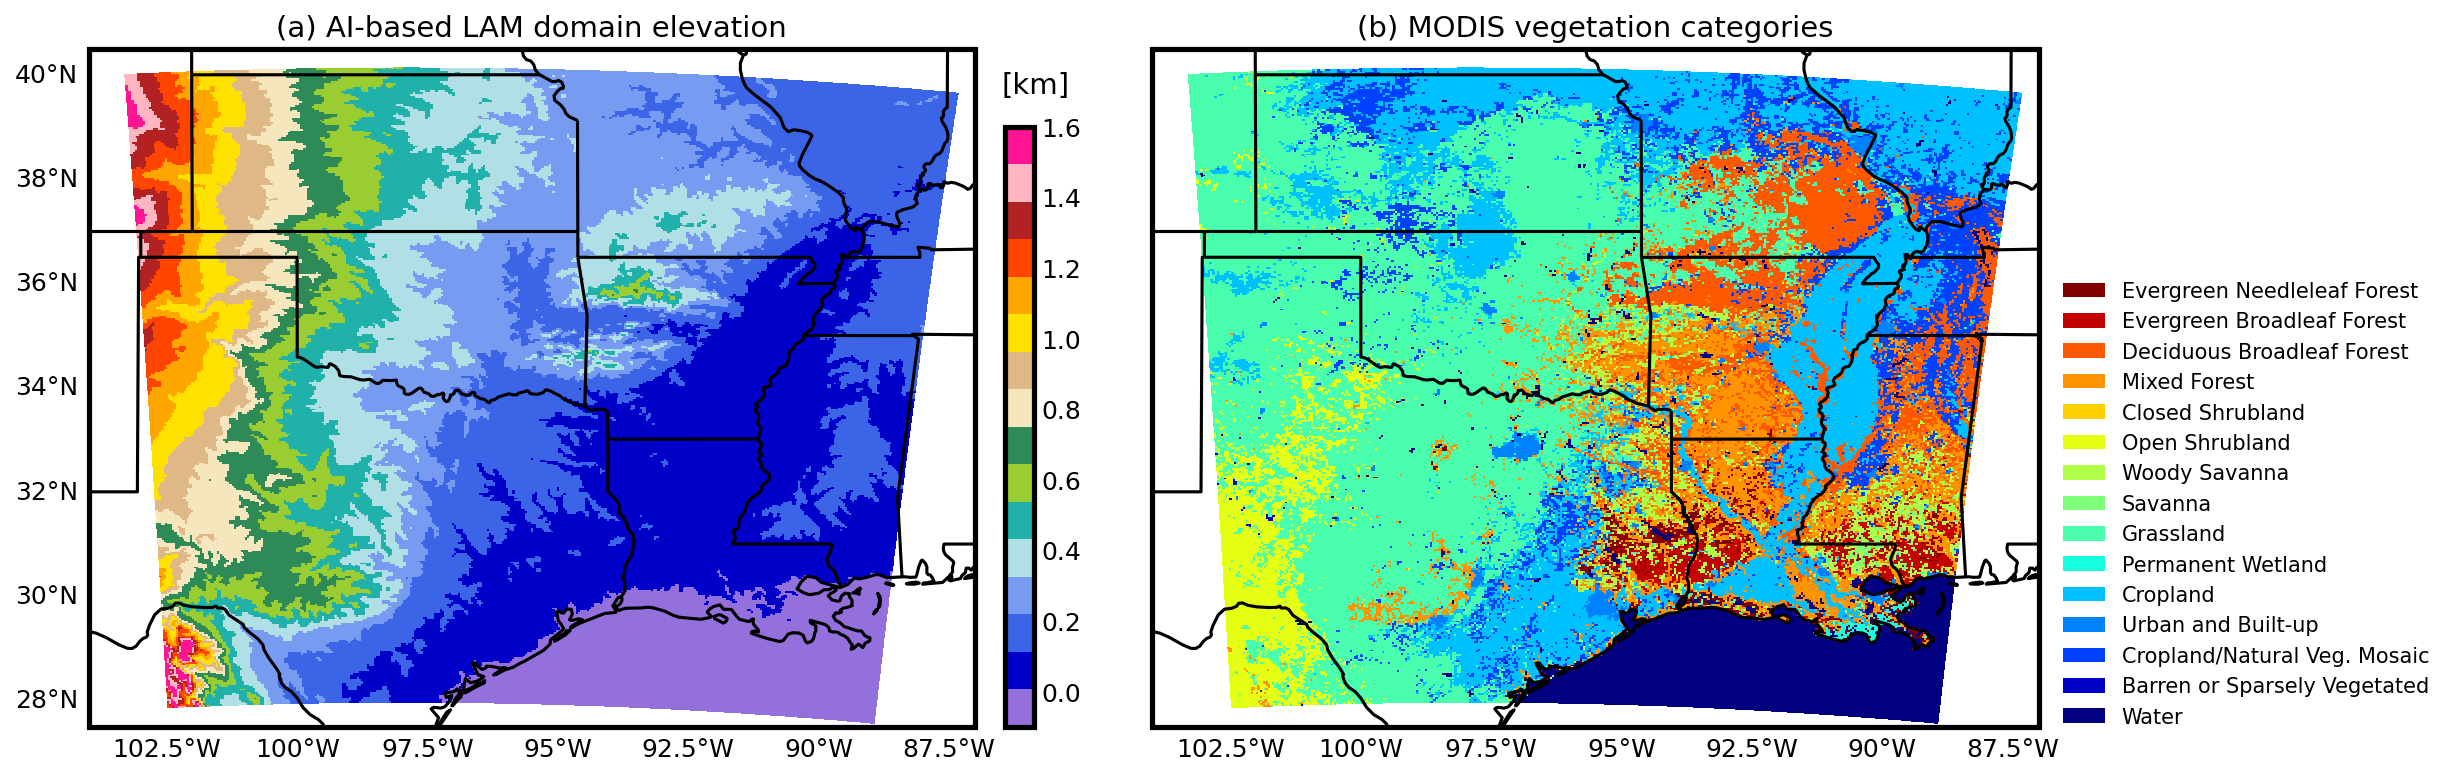

In [188]:
proj_ = ccrs.PlateCarree()
map_extent = [-104, -87, 27.5, 40.5]

fig = plt.figure(figsize=(13, 5), dpi=dpi_)
gs = gridspec.GridSpec(1, 2, height_ratios=[1,], width_ratios=[1, 1,])

AX_maps = []

AX_maps.append(plt.subplot(gs[0, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 1], projection=proj_))

for i_ax, ax in enumerate(AX_maps):
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)


for i_ax, ax in enumerate(AX_maps):
    GL = ax.gridlines(
        crs=ccrs.PlateCarree(), 
        draw_labels=True, x_inline=False, y_inline=False, 
        color=None, linewidth=0, zorder=5
    )
    
    GL.xlabel_style = {'size': 12}
    GL.ylabel_style = {'size': 12}
    GL.top_labels = None
    GL.right_labels = None
    if i_ax == 1:
        GL.left_labels = None
        
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.2)


vmin = int(lu.min())             # 1
vmax = int(lu.max())             # 17
cats = np.arange(vmin, vmax + 1) # [1..17]
boundaries = np.arange(vmin - 0.5, vmax + 1, 1)
norm = BoundaryNorm(boundaries, cmap_lu.N)
RGBs = cmap_lu(norm(cats))

CS1 = AX_maps[0].pcolormesh(lon_WRF, lat_WRF, 1e-3*elev, vmin=-0.1, vmax=1.6, cmap=cmap_elev, transform=ccrs.PlateCarree())
AX_maps[1].pcolormesh(lon_WRF, lat_WRF, lu, norm=norm, cmap=cmap_lu, transform=ccrs.PlateCarree())

AX_maps[0].text(1.03, 0.925, '[km]', ha='left', va='bottom', fontsize=14, transform=AX_maps[0].transAxes)

handle_legneds1 = []
label_names = []
for cat_ind in cat_valid:
    ind_ = int(cat_ind-1)
    rgb = RGBs[ind_, :]
    handle_legneds1.append(patches.Patch(facecolor=rgb, linewidth=0, label=' '))
    label_names.append(Noah_LU[ind_])

ax_lg1 = fig.add_axes([1.0, 0.048, 0.21, 0.619])
LG1 = ax_lg1.legend(
    handle_legneds1, label_names, 
    bbox_to_anchor=(1, 1), ncol=1, prop={'size':10}
)

ax_base1 = fig.add_axes([0.47, 0.048, 0.05, 0.8])
ax_base1.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1 = inset_axes(ax_base1, height='100%', width='30%', borderpad=0, loc=2)
CBar1 = plt.colorbar(CS1, orientation='vertical', cax=cax1)
CBar1.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar1.outline.set_linewidth(2.5)

AX_maps[0].set_title('(a) AI-based LAM domain elevation', fontsize=14)
AX_maps[1].set_title('(b) MODIS vegetation categories', fontsize=14)

# ax_title1.set_axis_off()
ax_base1.set_axis_off()
LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()